### Carga y Preparación de Datos

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



### Cargar archivos

In [176]:
# Cargar datos
data_path = 'data/ventas_solka_historico.csv'
data = pd.read_csv(data_path)

print(data)

        Producto_Key  Cliente_Key  Vendedor_Key  FechaVenta FechaDespacho  \
0                  1            2            11    6/1/2022      6/1/2022   
1                  1            2            11    6/1/2022      6/1/2022   
2                  1            2            11   17/2/2022     17/2/2022   
3                  1            2            11   17/2/2022     17/2/2022   
4                  1           20            38   13/6/2023     13/6/2023   
...              ...          ...           ...         ...           ...   
128134           177         3424             3    8/8/2023      9/8/2023   
128135           177         3424             3  17/11/2022    17/11/2022   
128136           177         3424             3    7/9/2023      7/9/2023   
128137           177         3432            38   6/11/2023     6/11/2023   
128138           177         3438            11  28/11/2023    28/11/2023   

       FechaEntrega  Cantidad  Precio    Total  Id_fact_det Bonif  
0      

In [177]:
# Visualizar las primeras filas
print(data.head())

# Resumen estadístico
print(data.describe())

# Verificar valores nulos
print(data.isnull().sum())


   Producto_Key  Cliente_Key  Vendedor_Key FechaVenta FechaDespacho  \
0             1            2            11   6/1/2022      6/1/2022   
1             1            2            11   6/1/2022      6/1/2022   
2             1            2            11  17/2/2022     17/2/2022   
3             1            2            11  17/2/2022     17/2/2022   
4             1           20            38  13/6/2023     13/6/2023   

  FechaEntrega  Cantidad  Precio    Total  Id_fact_det Bonif  
0     6/1/2022        15  110.60  1659.00       504567     N  
1     6/1/2022         3  110.60   331.80       504571     S  
2    17/2/2022        15  110.60  1659.00       513550     N  
3    17/2/2022         3  110.60   331.80       513551     S  
4    13/6/2023         7  114.92   804.44       594285     N  
        Producto_Key    Cliente_Key   Vendedor_Key       Cantidad  \
count  128139.000000  128139.000000  128139.000000  128139.000000   
mean      100.935851    1888.081419      16.870773      2

In [ ]:
# Distribución de cada columna
data.hist(figsize=(15, 10))
plt.show()

# Correlación entre variables
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


c:\Users\Luis Gonzalez Muller\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


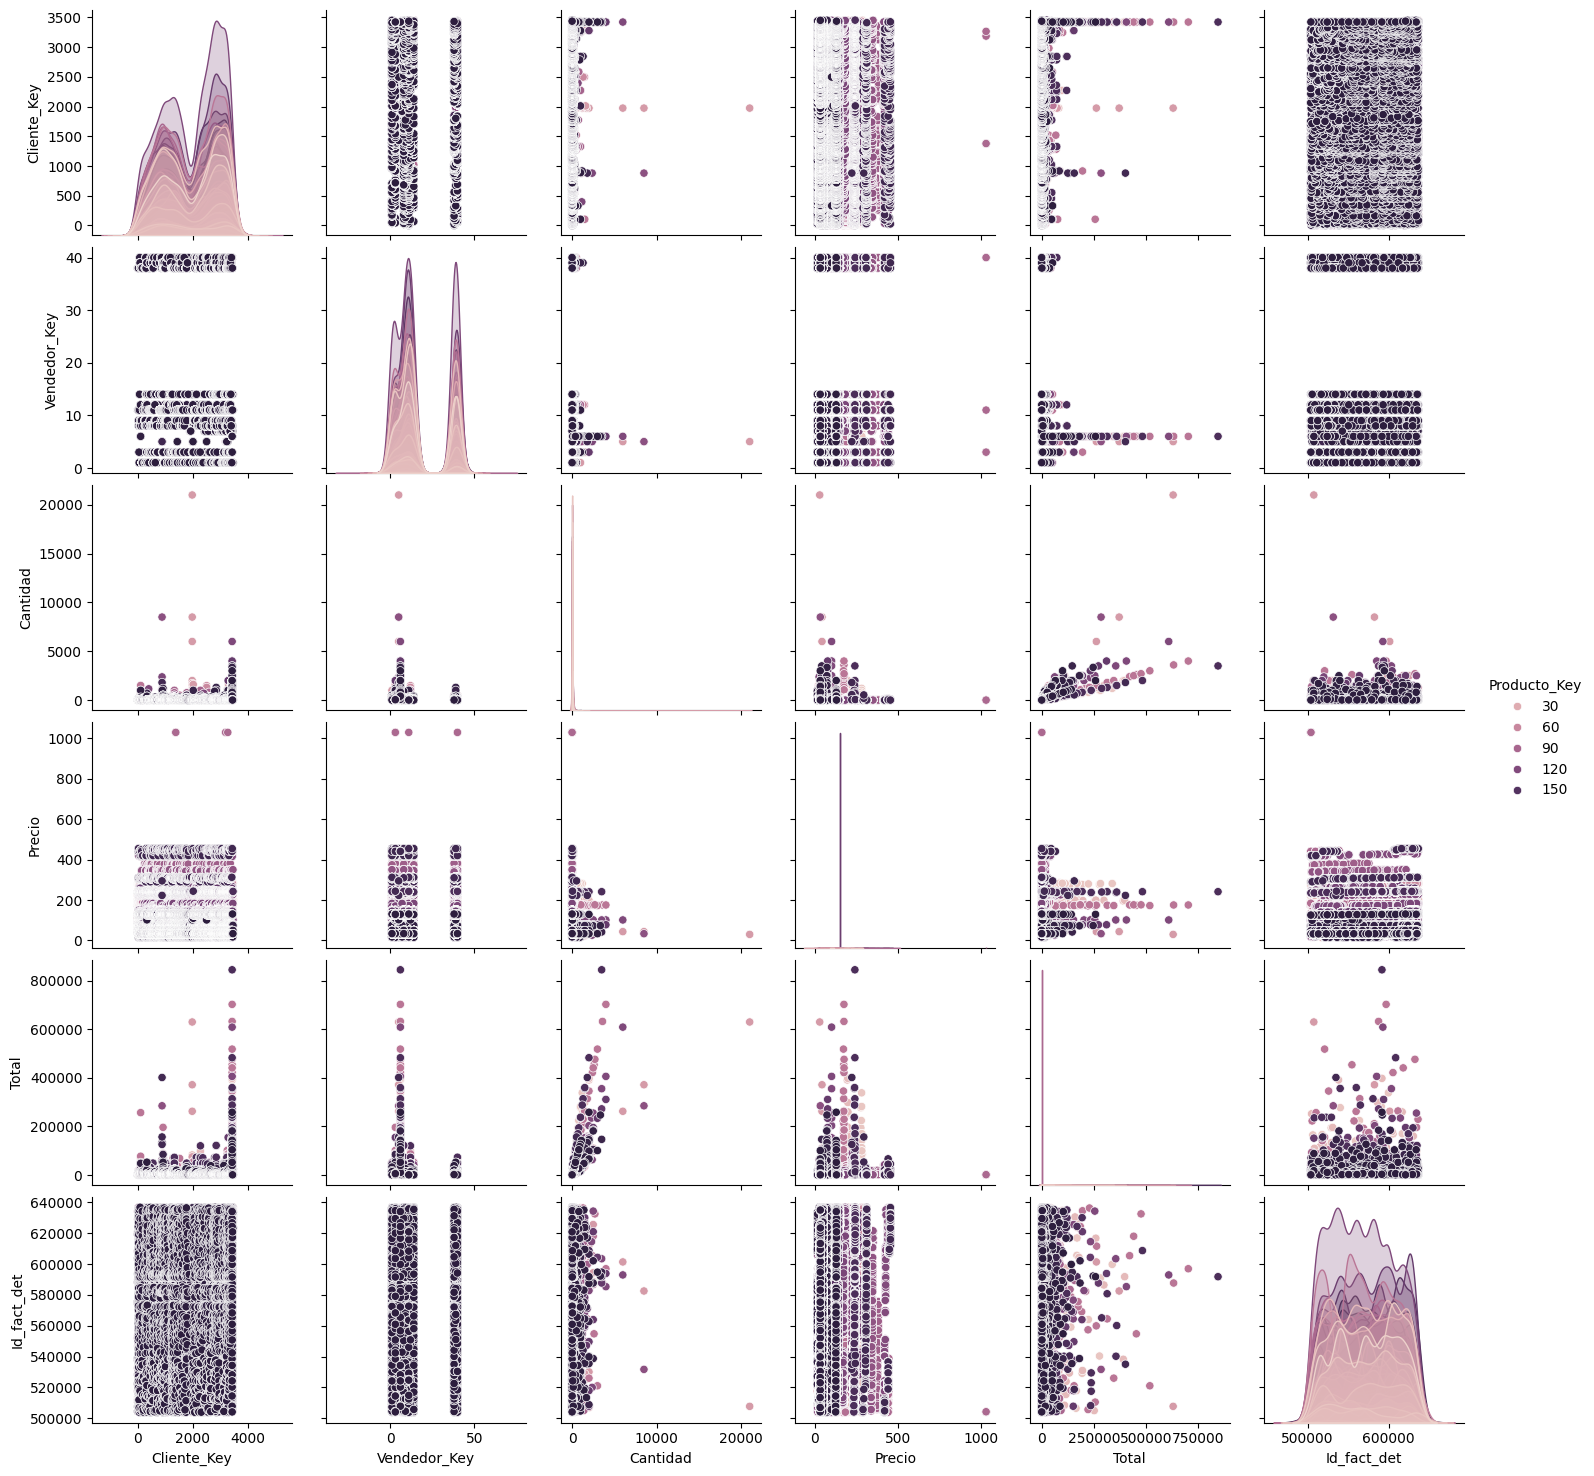

In [181]:
sns.pairplot(data, hue='Producto_Key')
plt.show()

In [155]:


# Convertir fechas a datetime especificando el formato
data['FechaVenta'] = pd.to_datetime(data['FechaVenta'], format='%d/%m/%Y')
data['FechaDespacho'] = pd.to_datetime(data['FechaDespacho'], format='%d/%m/%Y')
data['FechaEntrega'] = pd.to_datetime(data['FechaEntrega'], format='%d/%m/%Y')


# Extraer características de fecha
data['Year'] = data['FechaVenta'].dt.year
data['Month'] = data['FechaVenta'].dt.month
data['Day'] = data['FechaVenta'].dt.day
data['Weekday'] = data['FechaVenta'].dt.weekday

# Descartar columnas originales de fecha
data.drop(['FechaVenta', 'FechaDespacho', 'FechaEntrega'], axis=1, inplace=True)

# Codificar columna 'Bonif'
data['Bonif'] = data['Bonif'].apply(lambda x: 1 if x == 'S' else 0)

data.astype('Float32')

print(data)


        Producto_Key  Cliente_Key  Vendedor_Key  Cantidad  Precio    Total  \
0                  1            2            11        15  110.60  1659.00   
1                  1            2            11         3  110.60   331.80   
2                  1            2            11        15  110.60  1659.00   
3                  1            2            11         3  110.60   331.80   
4                  1           20            38         7  114.92   804.44   
...              ...          ...           ...       ...     ...      ...   
128134           177         3424             3        40  129.11  5164.40   
128135           177         3424             3        15  128.26  1923.90   
128136           177         3424             3        40  129.11  5164.40   
128137           177         3432            38        10  130.94  1309.40   
128138           177         3438            11         3  130.94   392.82   

        Id_fact_det  Bonif  Year  Month  Day  Weekday  
0      

In [156]:
# Normalización de los datos numéricos

numerical_features = ['Producto_Key','Cliente_Key','Vendedor_Key','Cantidad', 'Precio','Bonif','Year',  'Month', 'Day','Weekday','Total']
scaler = MinMaxScaler(feature_range=(0, 1))
data[numerical_features] = scaler.fit_transform(data[numerical_features])
valores = ['Cantidad','Precio','Total']

data = data[valores]
#data_.astype('float32')
#data_['Precio'] = round(data_['Precio'],6)

print(data)

          Precio     Total
0       0.094485  0.001945
1       0.094485  0.000374
2       0.094485  0.001945
3       0.094485  0.000374
4       0.098740  0.000934
...          ...       ...
128134  0.112713  0.006094
128135  0.111876  0.002259
128136  0.112713  0.006094
128137  0.114515  0.001531
128138  0.114515  0.000447

[128139 rows x 2 columns]


In [ ]:
#data= round(data,6)
#data_['Total'] = round(data_['Total'],6)

In [161]:

# Función para crear secuencias para LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i]['Total'])
    return np.array(X), np.array(y)

# Crear secuencias
n_steps = 1
X, y = create_sequences(data, n_steps)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Crear y entrenar el modelo

In [172]:


# Configurar Early Stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',     # Monitorea la pérdida de validación
    patience=4,            # Número de épocas sin mejora después de las cuales se detiene el entrenamiento
    min_delta=0.001,       # La cantidad mínima de cambio para cualificar como una mejora
    mode='min',            # "min" porque queremos minimizar la pérdida
    verbose=1,             # Mostrar mensajes cuando se detiene el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del modelo desde la época con la mejor pérdida observada
)


# Definir el modelo LSTM
model = Sequential([
    LSTM(80, activation='relu', input_shape=(n_steps, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(80, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, 
                    callbacks=[early_stopping_monitor]
                    )

# Realizar predicciones
predictions = model.predict(X_test).flatten()

# Asegurarse de que 'predictions' y 'y_test' tengan la misma longitud
if len(predictions) != len(y_test):
    min_len = min(len(predictions), len(y_test))
    predictions = predictions[:min_len]
    y_test = y_test[:min_len]


# Comparar predicciones con valores reales
comparison_df = pd.DataFrame({'Real': y_test, 'Predicciones': predictions})

# Mostrar las primeras filas del DataFrame para ver la comparación
print(comparison_df.head())




Epoch 1/10


c:\Users\Luis Gonzalez Muller\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3004/3004 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.2610e-04 - val_loss: 1.3233e-04
Epoch 2/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0953e-04 - val_loss: 1.2688e-04
Epoch 3/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1813e-04 - val_loss: 1.2482e-04
Epoch 4/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0988e-04 - val_loss: 1.2706e-04
Epoch 5/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0309e-04 - val_loss: 1.2552e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       Real  Predicciones
0  0.000617      0.004841
1  0.000322      0.003967
2  0.009183      0.004526
3  0.002047      0.005785
4  0.000752      0.004580


### Salida

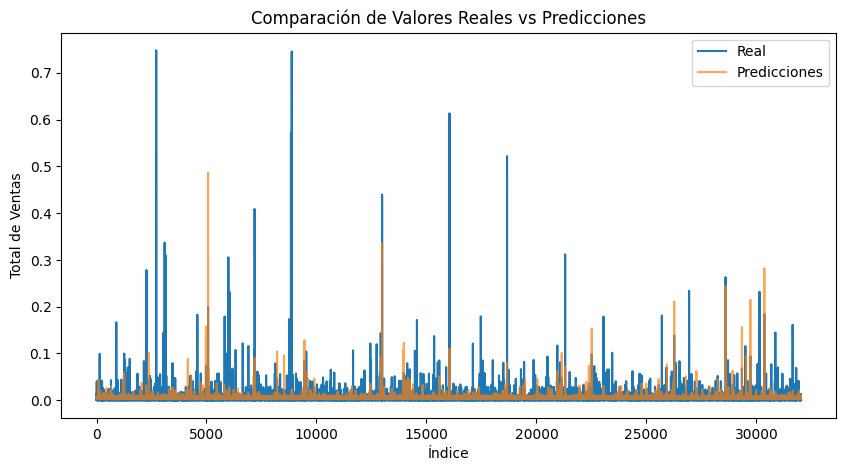

In [173]:
# Visualizar los resultados
plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Real'], label='Real')
plt.plot(comparison_df['Predicciones'], label='Predicciones', alpha=0.7)
plt.title('Comparación de Valores Reales vs Predicciones')
plt.xlabel('Índice')
plt.ylabel('Total de Ventas')
plt.legend()
plt.show()
